In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from astropy.table import Table
np.random.seed(42)
% matplotlib inline

In [2]:
# Read data
originaldata = Table.read('../data/star_data.fits', format='fits')
sp_names = np.asarray(['CI', 'CH', 'OI', 'NaI', 'MgI', 'AlI', 'SiI', 'SI', 'CaI', 'ScI',
       'ScII', 'TiI', 'TiII', 'VI', 'CrI', 'CrII', 'MnI', 'CoI', 'NiI',
       'CuI', 'ZnI', 'SrI', 'YII', 'ZrII', 'BaII', 'LaII', 'CeII', 'PrII',
       'NdII', 'SmII', 'EuII', 'GdII', 'DyII'])
sp_err_names = np.asarray(["{}_err".format(spn) for spn in sp_names])

In [3]:
# Make plot labels
labels = np.asarray(["[ {} / Fe ]".format(spn) for spn in sp_names])
labels

array(['[ CI / Fe ]', '[ CH / Fe ]', '[ OI / Fe ]', '[ NaI / Fe ]',
       '[ MgI / Fe ]', '[ AlI / Fe ]', '[ SiI / Fe ]', '[ SI / Fe ]',
       '[ CaI / Fe ]', '[ ScI / Fe ]', '[ ScII / Fe ]', '[ TiI / Fe ]',
       '[ TiII / Fe ]', '[ VI / Fe ]', '[ CrI / Fe ]', '[ CrII / Fe ]',
       '[ MnI / Fe ]', '[ CoI / Fe ]', '[ NiI / Fe ]', '[ CuI / Fe ]',
       '[ ZnI / Fe ]', '[ SrI / Fe ]', '[ YII / Fe ]', '[ ZrII / Fe ]',
       '[ BaII / Fe ]', '[ LaII / Fe ]', '[ CeII / Fe ]', '[ PrII / Fe ]',
       '[ NdII / Fe ]', '[ SmII / Fe ]', '[ EuII / Fe ]', '[ GdII / Fe ]',
       '[ DyII / Fe ]'], 
      dtype='<U13')

In [4]:
# make rectangular data                                                                                          
N = len(originaldata) # will be over-written
D = len(sp_names)
data = np.zeros((N, D))
data_err = np.zeros((N, D))
for d, (spn, spne) in enumerate(zip(sp_names, sp_err_names)):
    data[:, d] = originaldata[spn] # "log" b/c these are logarithmic abundances
    data_err[:, d] = originaldata[spne]

In [5]:
# FOR NOW: remove one bad object -- HACK
good = np.isfinite(data)
bad = ~good
mask = np.sum(bad, axis=1) == 0
data = data[mask] # remove one star with one missing abundance
data_err = data_err[mask]
N, D = data.shape # over-write

In [6]:
# make fake data with no structure
mean = np.mean(data, axis=0)
data_fake = mean[None, :] + np.random.normal(size=(N, D)) * data_err

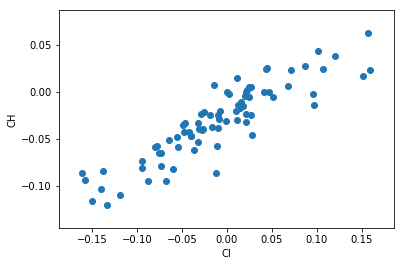

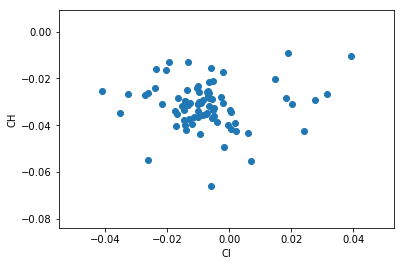

In [7]:
i, j = 0, 1
plt.scatter(data[:, i], data[:, j])
plt.xlabel(sp_names[i])
plt.ylabel(sp_names[j])
plt.figure()
plt.scatter(data_fake[:, i], data_fake[:, j])
plt.xlabel(sp_names[i])
plt.ylabel(sp_names[j])

In [8]:
def pca(data):
    mean = np.mean(data, axis=0)
    dd = data - mean[None, :]
    u, s, vecs = np.linalg.svd(dd, full_matrices=False)
    amps = u * s[None, :]
    # reconstrsyuction = mean[None, :] + np.dot(pcas, v)
    # print(data - reconstruction)
    return vecs, amps

In [9]:
# run PCA on the data
vecs, amps = pca(data)
eigenvals = np.sum(amps * amps, axis=0)
# run PCA on the random / fake data
fvecs, famps = pca(data_fake)
feigenvals = np.sum(famps * famps, axis=0)

(0.0001, 10.0)

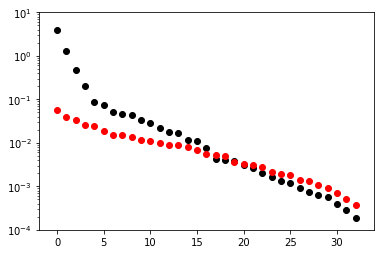

In [10]:
# compare data (black) and fake data (red) PCA amplitudes
plt.scatter(np.arange(len(eigenvals)), eigenvals, color="k")
plt.scatter(np.arange(len(feigenvals)), feigenvals, color="r")
plt.semilogy()
plt.ylim(0.0001, 10.)

In [11]:
# make a RANDOM rotation of the DATA
# that is, the real data, but rotated into a random basis
data_rotated = np.dot((data - mean[None, :]), fvecs.T)
data.shape, data_rotated.shape, data_fake.shape

((79, 33), (79, 33), (79, 33))

In [12]:
# Make point properties
cmap = cm.get_cmap("viridis")
colors = np.arange(N)[::-1]
# Make other plot properties
s = 5.
alpha = 0.5
foo = 2.5
figsize = (8 * foo, 4 * foo)
xlim = (-0.25, 0.45)

In [13]:
# plotting utility
def plot_data(data, labels):
    f, axlist = plt.subplots(4, 8, sharex=True, sharey=True, figsize=figsize)
    for i, ax in enumerate(axlist.flatten()):
        if (i + 1) >= D:
            break
        if i % 2:
            j, k = i+1, i
        else:
            j, k = i, i+1
        ax.scatter(data[:, j], data[:, k], s=s, c=colors, alpha=alpha, cmap=cmap)
        ax.set_xlabel(labels[j])
        ax.set_ylabel(labels[k])
        ax.set_xlim(xlim)
        ax.set_ylim(xlim)
    f.subplots_adjust(hspace=0.15)
    f.subplots_adjust(wspace=0.15)
    return f

In [14]:
# Plot data in the natural coordinates
f = plot_data(data - mean[None, :], labels)
plt.savefig("natural.png")
plt.close(f)

In [15]:
# Plot data in the PCA coordinates
pca_labels = np.asarray(["eigen {}".format(d) for d in range(D)])
f = plot_data(amps, pca_labels)
plt.savefig("pca.png")
plt.close(f)

In [16]:
# Plot data in randomly rotated coordinates
rand_labels = np.asarray(["random axis {}".format(d) for d in range(D)])
f = plot_data(data_rotated, rand_labels)
plt.savefig("random.png")
plt.close(f)

In [17]:
def get_vectors(vec1, vec2, K):
    """
    requires that vec1 and vec2 be perpendicular
    """
    dot = np.dot(vec1, vec2)
    vec2perp = vec2 - dot * vec1
    theta_max = np.arccos(dot)
    thetas = np.linspace(0., theta_max, K)
    vecs = np.cos(thetas)[:, None] * vec1[None, :] + np.sin(thetas)[:, None] * vec2perp[None, :]
    return vecs

In [18]:
%matplotlib

Using matplotlib backend: MacOSX


In [19]:
"""
plt.ioff()
plotnum = 0
thisvecs = np.eye(D)
thislabels = np.asarray(["" for d in range(D)])
for d in np.arange(D)[::-1]:
    v1 = np.zeros(D)
    v1[d] = 1
    v2 = vecs[d, :]
    rvecs = get_vectors(v1, v2, 8)
    for i, rvec in enumerate(rvecs):
        fn = "{0:04d}.png".format(plotnum)
        plotnum += 1
        thisvecs[d] = rvec
        thisdata = np.dot((data - mean[None, :]), thisvecs.T)
        thisdata.shape
        f = plot_data(thisdata, thislabels)
        plt.savefig(fn)
        plt.close(f)
"""

'\nplt.ioff()\nplotnum = 0\nthisvecs = np.eye(D)\nthislabels = np.asarray(["" for d in range(D)])\nfor d in np.arange(D)[::-1]:\n    v1 = np.zeros(D)\n    v1[d] = 1\n    v2 = vecs[d, :]\n    rvecs = get_vectors(v1, v2, 8)\n    for i, rvec in enumerate(rvecs):\n        fn = "{0:04d}.png".format(plotnum)\n        plotnum += 1\n        thisvecs[d] = rvec\n        thisdata = np.dot((data - mean[None, :]), thisvecs.T)\n        thisdata.shape\n        f = plot_data(thisdata, thislabels)\n        plt.savefig(fn)\n        plt.close(f)\n'